In [1]:
from data_master import DataMaster
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
master = DataMaster()
from scipy.stats import norm
from utils.func import *
from quantstats.stats import sharpe

In [32]:
mkt_data= extract_mkt_data('R1K')
gics = extract_gics('R1K')
gics
R = (mkt_data['close']/ mkt_data['close'].groupby(level=1).shift())-1
R = R.unstack()

In [3]:
universe = pd.read_parquet('data/SP500/universe_table.pq')
P = presence_matrix(universe)

In [9]:
rsi_index = rsi(mkt_data,10)
rsi_index= rank_ts(rsi_index,'RSI',10,ascending=True,pct=True,normalize=True)
rsi_index

c:\Users\marti\Documents\research perso\utils\func.py:188: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  column_rank =column.rolling(lookback).rank(axis=0,pct=pct,ascending=ascending).clip(0.01,0.99).apply(norm.ppf)


RSI_rank
Date       Ticker          
2000-01-14 AA     -0.524401
           AABA    1.281552
           AAPL    2.326348
           ABC     0.000000
           ABK    -0.841621
...                     ...
2023-03-24 YUM     0.253347
           ZBH    -1.281552
           ZBRA    0.000000
           ZION    0.524401
           ZTS     0.524401

[2949680 rows x 1 columns]

In [47]:
gics_hedge = gics['gicsubind']
gics.head()

,sector,industry,gicsect,gicgrp,gicind,gicsubind
AIZ,Financial Services,Insurance-Specialty,Financials,Insurance,Insurance,Multi-line Insurance
AL,Industrials,Rental & Leasing Services,Industrials,Capital Goods,Trading Companies & Distributors,Trading Companies & Distributors
DNB,Financial Services,Financial Data & Stock Exchanges,Industrials,Commercial & Professional Services,Professional Services,Research & Consulting Services
BERY,Consumer Cyclical,Packaging & Containers,Materials,Materials,Containers & Packaging,Metal & Glass Containers
MNST,Consumer Defensive,Beverages-Non-Alcoholic,Consumer Staples,"Food, Beverage & Tobacco",Beverages,Soft Drinks


C:\Users\marti\AppData\Local\Temp\ipykernel_21760\22315482.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(gics_hedge,axis=1).apply(center)


SHARPE    0.420387
dtype: float64

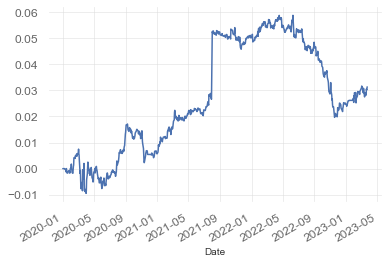

In [48]:
SIGNAL = rsi_index['RSI_rank'].unstack()[P].rank(pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
SIGNAL[SIGNAL.abs()<0.25]= None
SIGNAL = SIGNAL[P].groupby(gics_hedge,axis=1).apply(center)
SIGNAL = SIGNAL[P].div(SIGNAL[P].abs().sum(1),0)
pnl = (SIGNAL.shift()*R).sum(1).loc['2020':]
pnl.cumsum().plot()
pd.Series({'SHARPE':sharpe(pnl)})

In [85]:
gics_hedge = gics['gicsubind']
gics.head()

,sector,industry,gicsect,gicgrp,gicind,gicsubind
AIZ,Financial Services,Insurance-Specialty,Financials,Insurance,Insurance,Multi-line Insurance
AL,Industrials,Rental & Leasing Services,Industrials,Capital Goods,Trading Companies & Distributors,Trading Companies & Distributors
DNB,Financial Services,Financial Data & Stock Exchanges,Industrials,Commercial & Professional Services,Professional Services,Research & Consulting Services
BERY,Consumer Cyclical,Packaging & Containers,Materials,Materials,Containers & Packaging,Metal & Glass Containers
MNST,Consumer Defensive,Beverages-Non-Alcoholic,Consumer Staples,"Food, Beverage & Tobacco",Beverages,Soft Drinks


In [126]:
mkt_data['volume_dollar'] = (mkt_data['volume'] * mkt_data['close'])

In [135]:
adv = mkt_data['volume_dollar']#.groupby(level=0).rank(pct=False,ascending=False)
adv = adv.unstack().rolling(21).mean()
adv.stack().describe()
P = (adv>5e6)

C:\Users\marti\AppData\Local\Temp\ipykernel_21760\2918163586.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(gics_hedge,axis=1).apply(center)


SHARPE    2.042428
dtype: float64

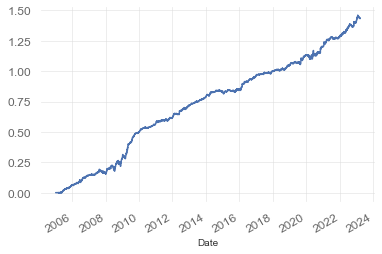

In [138]:
SIGNAL = (1 + R[P].rolling(20).sum()).rank(pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL = SIGNAL[P].ewm(alpha = 1/252).mean()
SIGNQL = SIGNAL.rolling(20).min()


SIGNAL = SIGNAL[P].rank(pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<0.1]= None
SIGNAL = SIGNAL[P].groupby(gics_hedge,axis=1).apply(center)
SIGNAL = SIGNAL[P].div(SIGNAL[P].abs().sum(1),0)
pnl = (SIGNAL[P].shift()*R).sum(1)
pnl.cumsum().plot()
pd.Series({'SHARPE':sharpe(pnl)})

<Axes: xlabel='Date'>

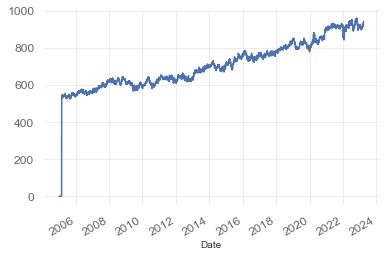

In [139]:
SIGNAL.count(1).plot()